### Here we try to fool other models using same adversarial images

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

### Just import the code

In [2]:
def build_graph():
  """build the same graph as previous dumped model

  Args:
    None

  Returns:
    sess          : tf.InteractiveSession()
    x             : tf.placeholder()
    y_            : tf.placeholder()
    y_pred,       : tf.Variable()
    keep_prob,    : tf.placeholder()
    cross_entropy : tf.Variable()

  Example:
    >>> build_graph()
  """
  x = tf.placeholder(tf.float32, shape=[None, 784])
  y_ = tf.placeholder(tf.float32, shape=[None, 10])

  def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
    
  def conv2d(x, W):
    """simple conv2d layer"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    """a simple 2x2 max pool layer"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  
  # First conv layer with a pool layer
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])

  x_image = tf.reshape(x, [-1,28,28,1])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  h_pool1 = max_pool_2x2(h_conv1)

  # Second conv layer with a pool layer
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])

  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pool_2x2(h_conv2)

  # First Full-connect layer
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Second Full-connect layer
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  # output layer
  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  y_pred = tf.nn.softmax(y_conv)
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
  
  sess = tf.InteractiveSession()
  return sess, x, y_, y_pred, keep_prob, cross_entropy

def generate_adversarial(model_path, img_list, target_class, eta=0.001, 
        threshold=0.99, save_path=None, file_name='adversarial', verbose=0):
  """generate adversarial images, note that gradient and some parts of 
    graph are needed during iterations, hence I decide not to pack some codes 
    into helper function

  Args:
    tensor_in: `Tensor`, input tensor.
    other_tensor_in: `Tensor`, same shape as `tensor_in`, other input tensor.
    my_param: `float`, coefficient for `tensor_in`.
    other_param: `float`, coefficient for `other_tensor_in`.
    output_collections: `tuple` of `string`s, name of the collection to
                        collect result of this op.
    name: `string`, name of the operation.

    model_path: `string`, the path to previous model
    img_list: `string`, the img list that need to generate adversarial images
    target_class: `int`, the wanted label
    eta: `float`, learning rate (or step size), default: 0.001
    threshold: `float`, the confidence we want to fool, default: 0.99 (99%)
    save_path: `string`, the path to img/ folder
    file_name: `string`, the name for saving file, default:'adversarial'
    verbose: `int`, verbose=0, omit the training graphs, default: 0

  Returns:
    `np.array`: the final adversarial image for each img in img_list

  Example:
    >>> generate_adversarial(model_path='../model/MNIST.ckpt', 
                img_list=img_list, target_class=6, eta=0.01, threshold=0.99, 
                save_path='../img/', file_name='adversarial', verbose=1)
    np.ndarray(...)
  """
  sess, x, y_, y_pred, keep_prob, cross_entropy = build_graph()

  sess.run(tf.global_variables_initializer())
  tf.train.Saver().restore(sess, model_path)
  print('load model from', model_path)
  
  prediction=tf.argmax(y_pred,1)
  probabilities=y_pred

  img_gradient = tf.gradients(cross_entropy, x)[0]

  adversarial_img_list = list()

  # generate versus figure
  sns.set_style('white')
  versus_fig = plt.figure(figsize=(9, 40))

  for img_index in range(0, img_list.shape[0]):
    adversarial_img = img_list[img_index: img_index+1].copy()
    adversarial_label = np.zeros((1, 10))
    adversarial_label[:, target_class] = 1
    
    confidence = 0
    iter_num = 0
    prob_history = list()
    while confidence < threshold:
      probabilities_val = probabilities.eval(feed_dict=
                        {x: adversarial_img, keep_prob: 1.0}, session=sess)
      confidence = probabilities_val[:, 6]
      prob_history.append(probabilities_val[0])
      
      gradient = img_gradient.eval(
          {x: adversarial_img, y_: adversarial_label, keep_prob: 1.0})
      adversarial_img -= eta * gradient
      iter_num += 1
    print('generate adversarial image after', iter_num, 'iterations')

    # generate versus figure

    ax1 = versus_fig.add_subplot(10, 3, 3*img_index+1)
    ax1.axis('off')
    ax1.imshow(img_list[img_index].reshape([28, 28]), 
              interpolation=None, cmap=plt.cm.gray)
    ax1.title.set_text(
          'Confidence for 2: ' + '{:.4f}'.format(prob_history[0][2]) 
          + '\nConfidence for 6: ' + '{:.4f}'.format(prob_history[0][6]))

    ax2 = versus_fig.add_subplot(10, 3, 3*img_index+2)
    ax2.axis('off')
    ax2.imshow((adversarial_img - img_list[img_index]).reshape([28, 28]),
                interpolation=None, cmap=plt.cm.gray)
    ax2.title.set_text('Delta')

    ax3 = versus_fig.add_subplot(10, 3, 3*img_index+3)
    ax3.axis('off')
    ax3.imshow((adversarial_img).reshape([28, 28]), 
                interpolation=None, cmap=plt.cm.gray)
    ax3.title.set_text(
          'Confidence for 2: ' + '{:.4f}'.format(prob_history[-1][2]) 
          + '\nConfidence for 6: ' + '{:.4f}'.format(prob_history[-1][6]))

    print("Difference Measure:", 
                      np.sum((adversarial_img - img_list[img_index]) ** 2))
    adversarial_img_list.append(adversarial_img)

    if verbose != 0:
      sns.set_style('whitegrid')
      colors_list = sns.color_palette("Paired", 10)
      # generate Iteration figure
      prob_history = np.array(prob_history)

      fig = plt.figure(figsize=(10, 6))
      ax = fig.add_subplot(111)

      for i, record in enumerate(prob_history.T):
          plt.plot(record, color=colors_list[i])

      ax.legend([str(x) for x in range(0, 10)], 
                  loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=14)
      ax.set_xlabel('Iteration')
      ax.set_ylabel('Prediction Confidence')
      fig.savefig(save_path + file_name + str(img_index) + '_iter.png')

  versus_fig.tight_layout()
  versus_fig.savefig(save_path + file_name + '_versus.png')
  return np.array(adversarial_img_list)

### Here we randomly select 10 images from mnist.test as input

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [4]:
%matplotlib inline

In [5]:
index_mask = np.where(mnist.test.labels[:, 2])[0]
subset_mask = np.random.choice(index_mask, 10)
origin_images = mnist.test.images[subset_mask]
origin_labels = mnist.test.labels[subset_mask]

### Call the function to get result

load model from ../model/MNIST.ckpt
generate adversarial image after 243 iterations
Difference Measure: 9.09434
generate adversarial image after 343 iterations
Difference Measure: 7.69538
generate adversarial image after 177 iterations
Difference Measure: 3.8366
generate adversarial image after 608 iterations
Difference Measure: 11.3014
generate adversarial image after 343 iterations
Difference Measure: 7.69525
generate adversarial image after 262 iterations
Difference Measure: 5.95166
generate adversarial image after 75 iterations
Difference Measure: 2.93704
generate adversarial image after 750 iterations
Difference Measure: 9.09427
generate adversarial image after 420 iterations
Difference Measure: 5.42159
generate adversarial image after 108 iterations
Difference Measure: 5.6366


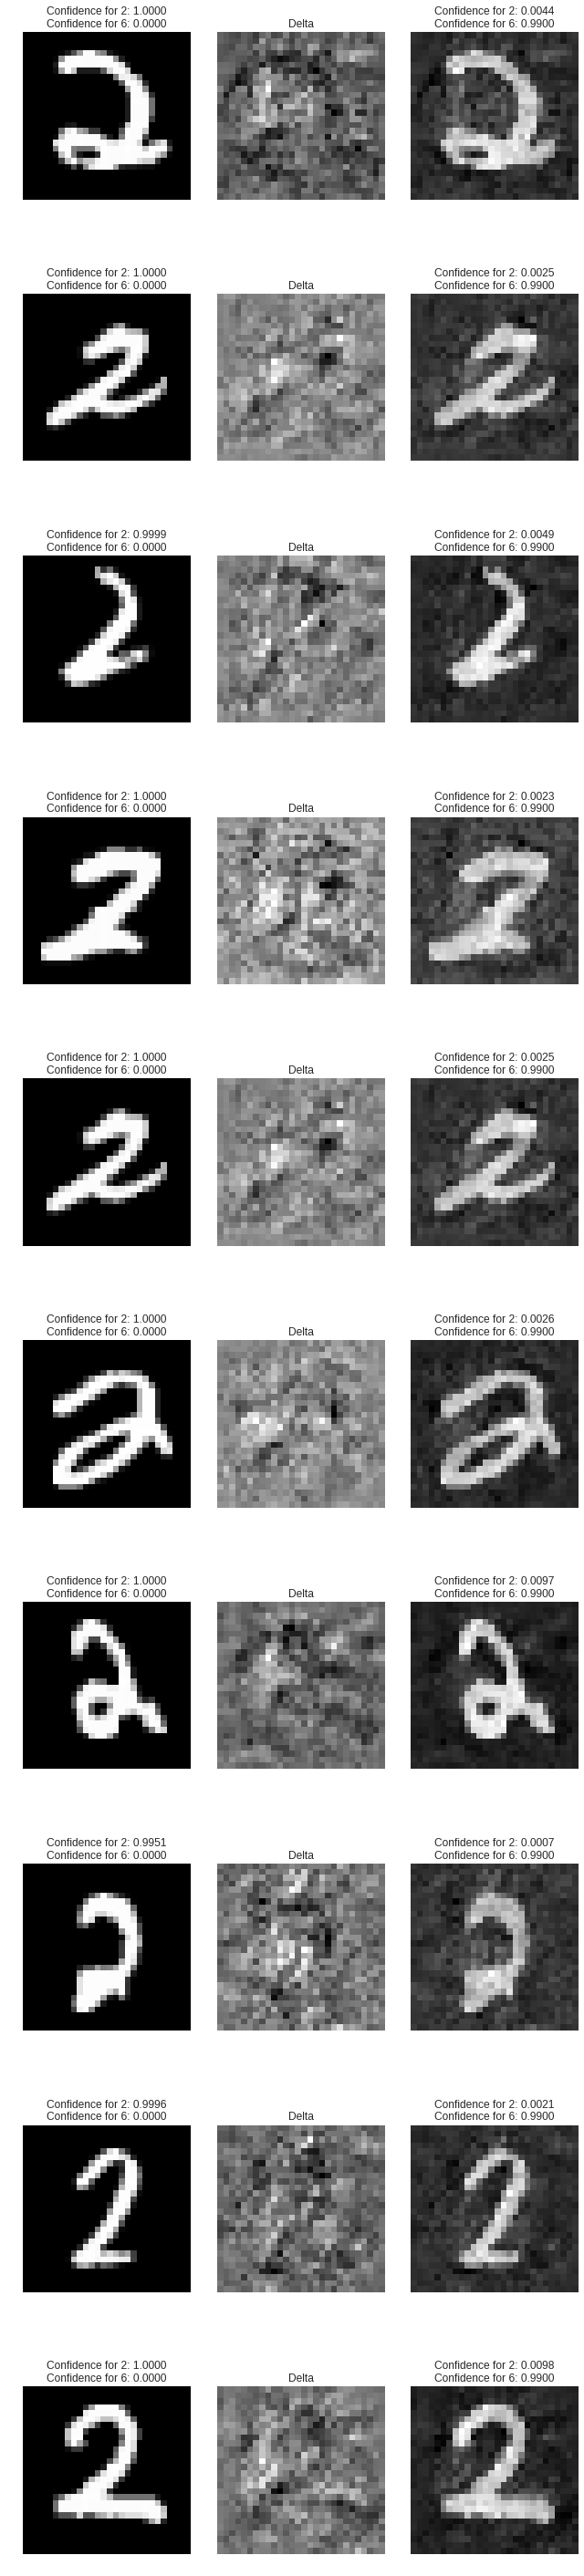

In [6]:
ad_img = generate_adversarial(model_path='../model/MNIST.ckpt', img_list=origin_images, target_class=6, eta=0.01, threshold=0.99, 
                        save_path='../img/', file_name='adversarial', verbose=0)

### Let 's s try to feed these adversarial images to different models

In [3]:
from sklearn import svm, metrics

In [4]:
train_images = mnist.train.images[:]
train_labels = mnist.train.labels[:]
test_images = mnist.test.images[:]
test_labels = mnist.test.labels[:]

In [8]:
train_labels = np.apply_along_axis(lambda x: np.where(x)[0][0], 1, train_labels)
test_labels = np.apply_along_axis(lambda x: np.where(x)[0][0], 1, test_labels)

### The first one is SVM(using SVC in scikit-learn), as the training process is slow, here only use first 10000 training images

In [10]:
classifier = svm.SVC(probability=True, verbose=True)

In [15]:
classifier.fit(train_images[0: 10000], train_labels[0: 10000])

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [33]:
pred_labels = classifier.predict(test_images)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, pred_labels))

Confusion matrix:
[[ 962    0    1    0    0    8    6    1    1    1]
 [   0 1121    2    3    0    2    3    0    4    0]
 [  15    3  924    9   12    3   20   15   28    3]
 [   2    2   20  927    0   20    3   12   19    5]
 [   1    6    7    0  899    0   13    2    2   52]
 [  10    8    5   44    9  781   15    3   12    5]
 [  11    3    6    1    8   13  915    0    1    0]
 [   2   21   21    5   11    1    0  938    5   24]
 [   6    9    9   19    8   33   13    8  854   15]
 [  13    9    1   11   34   10    1   16    4  910]]


In [34]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(test_labels, pred_labels)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True):
             precision    recall  f1-score   support

          0       0.94      0.98      0.96       980
          1       0.95      0.99      0.97      1135
          2       0.93      0.90      0.91      1032
          3       0.91      0.92      0.91      1010
          4       0.92      0.92      0.92       982
          5       0.90      0.88      0.89       892
          6       0.93      0.96      0.94       958
          7       0.94      0.91      0.93      1028
          8       0.92      0.88      0.90       974
          9       0.90      0.90      0.90      1009

avg / total       0.92      0.92      0.92     10000




In [27]:
pred_labels = classifier.predict(np.squeeze(ad_img))

In [28]:
pred_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 4])

### These images can not fool SVM, let's try RandomForest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
classifier = RandomForestClassifier(n_estimators=200)

In [39]:
classifier.fit(train_images, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [40]:
pred_labels = classifier.predict(test_images)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, pred_labels))
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(test_labels, pred_labels)))

Confusion matrix:
[[ 968    0    0    0    0    3    4    1    3    1]
 [   0 1125    2    2    0    2    2    0    1    1]
 [   5    0 1000    7    3    0    3    8    6    0]
 [   0    0   11  974    0    6    0    9    8    2]
 [   1    0    1    0  956    0    5    0    2   17]
 [   2    0    0   11    4  859    6    2    5    3]
 [   6    3    0    0    3    4  938    0    4    0]
 [   1    3   22    2    1    0    0  986    2   11]
 [   3    0    5    8    3    6    4    4  931   10]
 [   6    6    3    8   14    1    1    4    6  960]]
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    rec

In [41]:
pred_labels = classifier.predict(np.squeeze(ad_img))

In [42]:
pred_labels

array([2, 8, 8, 2, 2, 2, 2, 2, 2, 8])

### Even though the noise does confuse the classifier, the prediction label is not we want
### How a about a common LeNet?

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [18]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

input_shape = (img_rows, img_cols, 1)

batch_size = 128
nb_classes = 10
nb_epoch = 50

In [19]:
train_images = mnist.train.images.reshape((55000, 28, 28, 1))
train_labels = mnist.train.labels
test_images = mnist.test.images.reshape((10000, 28, 28, 1))
test_labels = mnist.test.labels

valid_images = mnist.validation.images.reshape((5000, 28, 28, 1))
valid_labels = mnist.validation.labels

In [20]:
model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(valid_images, valid_labels))

In [21]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0306128276816
Test accuracy: 0.991


In [22]:
model.predict(ad_img.reshape((10, 28, 28, 1)))

array([[  6.00433941e-06,   5.20795879e-07,   9.96605277e-01,
          3.36286286e-03,   2.46108982e-08,   2.73512697e-08,
          6.82997436e-10,   2.81186857e-07,   2.22933668e-05,
          2.79486949e-06],
       [  6.19925868e-06,   5.65824390e-04,   9.87202704e-01,
          1.11195054e-02,   2.31055110e-05,   3.90526202e-06,
          5.11477174e-06,   7.03725324e-04,   3.63981846e-04,
          5.98347060e-06],
       [  5.38399902e-08,   5.13083578e-05,   9.97262955e-01,
          2.65042088e-03,   3.31562120e-07,   2.84679780e-10,
          2.38823901e-07,   3.39144353e-05,   7.66287201e-07,
          1.51679924e-09],
       [  4.54879628e-05,   2.78240349e-02,   8.73205364e-01,
          9.19484869e-02,   1.77355628e-06,   1.03264625e-04,
          4.38309326e-06,   3.09151085e-03,   3.74361919e-03,
          3.20698891e-05],
       [  6.19954244e-06,   5.65640396e-04,   9.87206459e-01,
          1.11163044e-02,   2.31009508e-05,   3.90349351e-06,
          5.11413782e-06

In [23]:
model.predict_classes(ad_img.reshape((10, 28, 28, 1)))

10/10 [==============================] - 0s


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### From these result, we can conclude that adversarial images cannot apply to different models